#### Importing modules

In [5]:
import os
import pandas as pd
pd.set_option('max_colwidth', None)
pd.set_option('max_columns', None)
import numpy as np; np.random.seed(0)
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
# from datetime import datetime
from IPython.display import clear_output as co

from sklearn.preprocessing import binarize 
from sklearn.metrics import classification_report as cr
import sklearn.metrics as metrics
from imblearn.under_sampling import RandomUnderSampler

from sklearn.utils import all_estimators; classifiers = dict(all_estimators('classifier'))
from sklearn.model_selection import (
    train_test_split as tts
)
from cv_samplers import GroupUnderSampleSplit, target_categorical_distribution, categorical_undersampling
# from CategoricalSampler import target_categorical_distribution, categorical_undersampling, tts_categorical
# from Classification import Classifier, plot_lc_model_comparison
# from NeuralNetwork import execute_neural_net, plot_learning_curve_comparison

C:\Users\luisr\anaconda3\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


---
# LOADING DATA

In [6]:
data = pd.read_csv('data/grades/5th_grade.csv', index_col=0)
data.drop('ID_ALUNO', 1, inplace=True)

# Loading data information dictionaries
data_path = '/Users/luisr/Desktop/Repositories/Data/saep/CSV/{}'
grades = [5,9,3]; dict_filenames = [f'dicionario {i}ano.csv' for i in grades]
dicts = {grade: pd.read_csv(data_path.format(filename)).set_index('questão') for grade, filename in zip(grades, dict_filenames)}

#### Defining targets corresponding to each student grade
targets = { # Abandonment
    5: 'TX_RESP_Q049',
    9: 'TX_RESP_Q050',
    12: 'TX_RESP_Q044',
}
grade = 5
target = targets[grade]

#### List different types of features
ids = data.columns[:10].tolist()
questions = data.columns[10:64].tolist()
grades = data.columns[64:].tolist()

---
# DATA TRANSFORMATION

In [7]:
# eliminate rows where the target variable value is missing. obs: last label represent missing values (Label 3)
modeling_data = data[data[target]!=data[target].max()].copy()
# target variable binary conversion
modeling_data[target] = binarize(modeling_data[[target]], threshold=0.5).reshape(-1)

# define X and Y
Y = modeling_data[target].copy()
X = modeling_data.drop(target, 1)

# FILLING MISSING VALUES WITH VARIABLES' MEANS
for grade in grades:
    X[grade].fillna(X[grade].mean(), inplace=True)
    
# target variable class count
display(Y.value_counts().rename('Target variable class count').to_frame())

,Target variable class count
0,397232
1,50087


---
# USE CASE EXAMPLES FOR GROUP UNDER SAMPLING CLASS METHODS
* GroupUnderSampleSplit(
    n_splits=5,
    train_size=0.3, train_prct=3,
    test_size=0.3, test_prct=3,
    group_col=None, key_col='ID_MUNICIPIO',
    positional_index=False,
    random_state=1, verbose=1
)
* single_split_index(_x, _y, cnt=None, shuffle=False, random_state=0)
* undersample(_x, _y, cnt=None, shuffle=False, random_state=None)
* train_test_split_index(_x, _y, cnt=None, shuffle=False, random_state=None)split(x, y, shuffle=True)
* train_test_undersample( _x, _y, cnt=None, shuffle=False, random_state=None)
* split(x, y, shuffle=True)

#### Defining functions

In [8]:
def print_cls_cnt(Y, t_ind, e_ind):
    cls_cnt = pd.concat([Y[ind].value_counts().rename(col).to_frame() for ind, col in zip([t_ind, e_ind], ['Train set', 'Test set'])], 1)
    cls_cnt.index.name = 'Class'
    display(cls_cnt)

def cv_df(cv_res, scoring):
    return pd.DataFrame({scr: cv_res['test_'+scr] for scr in scoring})

# GroupUnderSampleSplit class instance

# Simple under sample split

### Under sample both classes for training (all left for testing)

##### 1/1 balanced train sample and test sample indexes

##### Parameters:
* 'train_size': float between 1. and 0. - fraction of samples in the minority class to select for training.
* 'train_prct': float larger than 0. - ratio of majority/minority class samples in the training set.

In [5]:
# instantiate class object
guss = GroupUnderSampleSplit(
#     train_size=0.3, train_prct=1
)
t_index, e_index = guss.single_split_index(
    X, Y, train_size=0.2, train_prct=1, #cnt=None, shuffle=False, random_state=0
)
print_cls_cnt(Y, t_index, e_index)

,Train set,Test set
Class,,
0,10017,387215
1,10017,40070


#### Train and test x and y dataframes

Corresponds to the same splitting above, but returns splitted x and y train and test sets instead of train and test indexes.

In [6]:
xt, xe, yt, ye = guss.undersample(
    X, Y, #cnt=None, shuffle=False, random_state=None
)
print_cls_cnt(Y, yt.index, ye.index)

,Train set,Test set
Class,,
0,40069,357163
1,40070,10017


# Train and test under sample splits

### Under sample both classes for training and testing

Corresponds to the same splitting above, but returns splitted x and y train and test sets instead of train and test indexes.

In [7]:
guss = GroupUnderSampleSplit(
#     n_splits=2,
    train_size=0.2, train_prct=1,             # related to minority class size in given sample   # related to minotiy class size in train and test sets
    test_size=0.6, test_prct=6,
)

#### 3/1 imbalanced train sample and 8/1 imbalanced test sample  indexes for 4% of the minority class for training and 30% for testing

In [8]:
t_index, e_index = guss.train_test_split_index(
    X, Y, # cnt=None, shuffle=False, random_state=0
)
print_cls_cnt(Y, t_index, e_index)

,Train set,Test set
Class,,
0,10017,180315
1,10017,30052


#### Train and test x and y dataframes

Corresponds to the same splitting above, but returns splitted x and y train and test sets instead of train and test indexes.

In [9]:
xt, xe, yt, ye = guss.train_test_undersample(
    X, Y, # cnt=None, shuffle=False, random_state=0
)
print_cls_cnt(Y, yt.index, ye.index)

,Train set,Test set
Class,,
0,10017,180315
1,10017,30052


# Train and test under sample per category

### Under sample classes for train and test samples by under sampling each category independently (with replacement if rounded train_prct * n_minority_samples > n_majority_samples)

In [10]:
key_col = 'ID_MUNICIPIO'

In [11]:
guss = GroupUnderSampleSplit(
    train_size=0.2, train_prct=1,             # related to minority class size in given sample   # related to minotiy class size in train and test sets
    test_size=0.6, test_prct=6,
#     group_col=group_col,
    key_col=key_col,
)

#### Train and test x and y dataframes

In [12]:
xt, xe, yt, ye = guss.train_test_undersample(X, Y, cnt=None, shuffle=False, random_state=0)
print_cls_cnt(Y, yt.index, ye.index)

,Train set,Test set
Class,,
0,10017,180315
1,10017,30052


#### Key class count for minority and majority class

##### In the train set

In [13]:
tcd = target_categorical_distribution(xt, yt, col=key_col, verbose=1); tcd

ID_MUNICIPIO evaluated: 927/927


,0,1,2,3,4,6,7,8,9,10,...,1037,1038,1039,1040,1041,1042,1043,1044,1045,1046
0,3,20,0.0,11,2,0.0,4,6,10,14,...,3,20,3,9,5,1,11,5,11,7
1,3,20,1.0,4,4,1.0,2,4,14,12,...,1,19,5,12,1,1,8,4,17,9


##### In the test set

In [14]:
tcd = target_categorical_distribution(xe, ye, col=key_col, verbose=1); tcd

ID_MUNICIPIO evaluated: 1008/1008


,0,1,3,4,5,6,7,8,9,10,...,1037,1038,1039,1040,1041,1042,1043,1044,1045,1046
0,44,418,253,29,25,29,41,98,237,195,...,30,398,65,195,88,66,173,115,361,157
1,7,73,43,5,3,4,7,14,39,35,...,3,71,11,34,12,10,30,22,62,27


# Train and test under sample + group shuffle split

#### Under sample each category independently then group shuffle split categories by specified sample size - for train set then for test set independently

In [15]:
# key_col = 'ID_MUNICIPIO'
group_col = 'ID_MUNICIPIO'

In [16]:
guss = GroupUnderSampleSplit(
#     n_splits=2,
    train_size=0.04, train_prct=1,             # related to minority class size in given sample   # related to minotiy class size in train and test sets
    test_size=0.3, test_prct=6,
    group_col=group_col,
#     key_col=key_col
)

#### Train and test x and y dataframes

In [17]:
xt, xe, yt, ye = guss.train_test_undersample(X, Y, cnt=None, shuffle=False, random_state=None)
print_cls_cnt(Y, yt.index, ye.index)

,Train set,Test set
Class,,
0,1297,88963
1,1292,15030


#### Key class count for minority and majority class

##### In the train set

In [18]:
tcd = target_categorical_distribution(xt, yt, col=key_col, verbose=1); tcd

ID_MUNICIPIO evaluated: 42/42


,9,38,61,67,70,105,179,221,226,230,...,795,802,820,835,860,910,950,965,973,994
0,90,8,5,8,43,11,31,58,15,65,...,1,2,10,3,8,21,14,78,71,47
1,67,7,23,20,46,20,44,65,18,65,...,3,4,12,1,3,17,5,65,48,44


##### In the test set

In [19]:
tcd = target_categorical_distribution(xe, ye, col=key_col, verbose=1); tcd

ID_MUNICIPIO evaluated: 324/324


,0,2,3,5,7,12,14,25,26,29,...,1027,1030,1031,1033,1038,1039,1041,1043,1044,1045
0,98,57,648,103,141,302,277,70,156,43,...,99,208,311,523,1792,151,225,461,138,772
1,12,1,59,5,12,56,34,8,21,3,...,16,33,44,78,103,18,20,47,29,97


# Train and test under sample per category + group shuffle split

#### Under sample each category independently then group shuffle split categories by specified sample size - for train set then for test set independently

In [20]:
key_col = 'ID_MUNICIPIO'
group_col = 'ID_MUNICIPIO'

In [21]:
guss = GroupUnderSampleSplit(
    train_size=0.2, train_prct=1,
    test_size=0.6, test_prct=6,
    group_col=group_col,            # group shuffle split
    key_col=key_col                 # under sampling per group
)

#### Train and test x and y dataframes

In [22]:
xt, xe, yt, ye = guss.train_test_undersample(X, Y, cnt=None, shuffle=False, random_state=None)
print_cls_cnt(Y, yt.index, ye.index)

,Train set,Test set
Class,,
0,9891,173436
1,9891,28906


#### Key class count for minority and majority class

##### In the train set

In [23]:
tcd = target_categorical_distribution(xt, yt, col=key_col, verbose=1); tcd

ID_MUNICIPIO evaluated: 229/229


,4,6,11,12,22,29,51,62,67,75,...,1024,1025,1027,1028,1029,1031,1036,1040,1044,1045
1,11,8,96,56,26,3,9,11,20,40,...,47,32,16,25,95,44,29,54,29,97
0,11,8,96,56,26,3,9,11,20,40,...,47,32,16,25,95,44,29,54,29,97


##### In the test set

In [24]:
tcd = target_categorical_distribution(xe, ye, col=key_col, verbose=1); tcd

ID_MUNICIPIO evaluated: 588/588


,0,1,3,7,8,9,10,15,16,17,...,1032,1034,1035,1037,1038,1039,1041,1042,1043,1046
0,72,660,354,72,156,402,330,72,3636,48,...,390,30,132,42,618,108,120,90,282,264
1,12,110,59,12,26,67,55,12,606,8,...,65,5,22,7,103,18,20,15,47,44


Obs: group_col categories' target class percentage matches perfectly with train_prct and test_prct arguments and key_col categories' are mutually exclusive in train and test sets

# Train and test under sample cross validation splits

### Under sample classes for train and test samples for 'n' random shuffle splits

In [25]:
guss = GroupUnderSampleSplit(
    n_splits=5,
    train_size=0.2, train_prct=1,             # related to minority class size in given sample   # related to minotiy class size in train and test sets
    test_size=0.6, test_prct=6,
    key_col='ID_MUNICIPIO',
    group_col='ID_MUNICIPIO',
)

In [26]:
cv = guss.split(X, Y, shuffle=False)

Performing splits - 1/5 splits performed.


Obs: Cross validation splits can be performed for any argument combination examplified above

In [27]:
t_index, e_index = cv[0][0], cv[0][1]
print_cls_cnt(Y, t_index, e_index)

,Train set,Test set
Class,,
0,10007,180024
1,10007,30004


#### Key class count for minority and majority class

In [28]:
xt, xe, yt, ye = X.loc[t_index], X.loc[e_index], Y.loc[t_index], Y.loc[e_index]

##### In the train set

In [29]:
tcd = target_categorical_distribution(xt, yt, col=key_col, verbose=1); tcd

ID_MUNICIPIO evaluated: 272/272


,1,2,5,8,14,18,27,30,31,35,...,1002,1004,1006,1013,1015,1019,1030,1041,1042,1046
1,110,1,5,26,34,6,28,26,32,10,...,6,59,25,12,9,28,33,20,15,44
0,110,1,5,26,34,6,28,26,32,10,...,6,59,25,12,9,28,33,20,15,44


##### In the test set

In [30]:
tcd = target_categorical_distribution(xe, ye, col=key_col, verbose=1); tcd

ID_MUNICIPIO evaluated: 586/586


,0,3,4,6,7,9,10,11,12,15,...,1032,1033,1034,1035,1037,1038,1039,1040,1043,1044
0,72,354,66,48,72,402,330,576,336,72,...,390,468,30,132,42,618,108,324,282,174
1,12,59,11,8,12,67,55,96,56,12,...,65,78,5,22,7,103,18,54,47,29


---
# COMPARING CV SPLITS USING PIPELINE

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_validate as CV
from sklearn.decomposition import PCA
from sklearn.ensemble import (
    GradientBoostingClassifier as GBC,
    RandomForestClassifier as RFC,
    BaggingClassifier as BC,
)
from sklearn.linear_model import LogisticRegressionCV as LRCV, RidgeClassifierCV as RCCV
from sklearn.svm import SVC
from sklearn import metrics
from imblearn.ensemble import (
    BalancedBaggingClassifier as BBC,
    BalancedRandomForestClassifier as BRFC,
    RUSBoostClassifier as RUSBC
)

In [2]:
def grid_search_split(X, Y, param_grid, reset_index=True, shuffle=True, random_state=0, verbose=1):

    key_cols = [param_grid[key]['key_col'] for key in param_grid.keys()]
    key_col_uniform = (
        np.any(list(map(lambda col: col is not None, key_cols)))
#         np.any([param_grid[key]['key_col'] is not None for key in param_grid.keys()])
        and
        1 == len(np.unique(list(filter(lambda col: col is not None, key_cols))))
    )
    key_col = key_cols[0] if key_col_uniform else None
    cnt_base = None if not key_col_uniform else target_categorical_distribution(X, Y, col=key_col, verbose=1)

    cv = []
    for i, (key, params) in enumerate(param_grid.items()):
        if verbose: co(wait=True); print(f'Grid search split - {i}/{len(param_grid)} splits performed.')
        splitter = GroupUnderSampleSplit(
            **params,
            reset_index=reset_index,
            verbose=int(verbose==0)
        )
        cnt = None if params['key_col'] is None else cnt_base
        t_index, e_index = splitter.train_test_split_index(
            X, Y,  cnt, shuffle, random_state
        )
        cv.append((t_index, e_index))
    print(f'Done! {len(param_grid)}/{len(param_grid)} splits performed.')
    return cv

## Optimizing target class ratio using cross validation

In [ ]:
recall_0, recall_1 = (metrics.make_scorer(metrics.recall_score, pos_label=i) for i in (0, 1))
scoring = {
#     'accuracy': 'accuracy',
    'f1':'f1', #'f1_macro': 'f1_macro',
    'recall_macro': 'recall_macro',# 'precision_macro': 'precision_macro',
    'recall_0': recall_0, 'recall_1': recall_1,
#     'precision_0': precision_0, 'precision_1': precision_1,
}

def exponential(n=12, maximum=10, order=2, slope=0):
    return slope + maximum * np.linspace(.1, 1, n)**order

train_prct_params = exponential(n=12, maximum=6, order=4)

param_grid = { str(train_prct): dict(
    train_size=0.06,
    train_prct=train_prct,
    test_size=0.2,
    test_prct=6,
    key_col='ID_MUNICIPIO',
#     group_col='ID_MUNICIPIO',
) for train_prct in train_prct_params }

cv = grid_search_split(X, Y, param_grid, reset_index=True, shuffle=True, random_state=0, verbose=1)

t_index, e_index = cv[0][0], cv[0][1]
print_cls_cnt(Y.reset_index(drop=True), t_index, e_index)

model_cv = CV(RUSBC(n_estimators=60), X, Y, cv=cv, scoring=scoring, groups=None, n_jobs=-1, pre_dispatch='all', verbose=5)

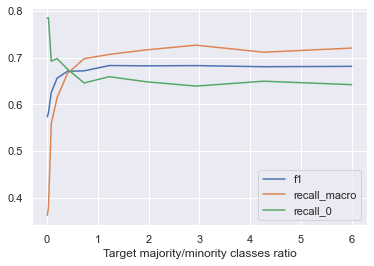

In [10]:
cv_df = pd.DataFrame({scr: model_cv['test_'+scr] for scr in scoring})

fig, ax = plt.subplots()
ax.plot(train_prct_params, cv_df.iloc[:, 1:])
plt.xlabel('Target majority/minority classes ratio')
plt.legend(labels=scoring.keys())
plt.show()